In [14]:
import torch
import torchvision
import torchvision.transforms as transforms

In [15]:
transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle = True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle = False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


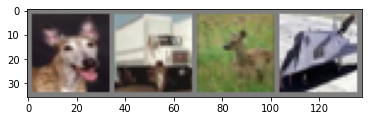

  dog truck  deer plane


In [16]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img/2 +0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.show()
    
dataiter = iter(trainloader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))
print(' '.join('%5s'% classes[labels[j]] for j in range(4)))

In [17]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5) # 3 input, 6 output, 5*5 kernel
        self.pool = nn.MaxPool2d(2, 2) # 2*2 max pooling
        self.conv2 = nn.Conv2d(6, 16, 5) # 6 input, 16 output, 5*5 kernel
        self.fc1 = nn.Linear(16 * 5 * 5, 120) # 16*5*5 를 120짜리로 affine 변환?
        self.fc2 = nn.Linear(120, 84) # 
        self.fc3 = nn.Linear(84, 10) # 결국 10짜리 나옴.

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x))) # conv -> relu -> max pool
        x = self.pool(F.relu(self.conv2(x))) # conv -> relu -> max pool
        x = x.view(-1, 16 * 5 * 5) 
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

In [18]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [19]:
for epoch in range(2):   # 데이터셋을 수차례 반복합니다.

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # [inputs, labels]의 목록인 data로부터 입력을 받은 후;
        inputs, labels = data

        # 변화도(Gradient) 매개변수를 0으로 만들고
        optimizer.zero_grad()

        # 순전파 + 역전파 + 최적화를 한 후
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # 통계를 출력합니다.
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0
    print(i)
print('Finished Training')

[1,  2000] loss: 2.241
[1,  4000] loss: 1.889
[1,  6000] loss: 1.699
[1,  8000] loss: 1.600
[1, 10000] loss: 1.541
[1, 12000] loss: 1.475
12499
[2,  2000] loss: 1.402
[2,  4000] loss: 1.376
[2,  6000] loss: 1.337
[2,  8000] loss: 1.306
[2, 10000] loss: 1.294
[2, 12000] loss: 1.264
12499
Finished Training


In [20]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

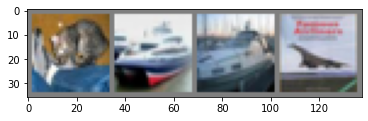

GroundTruth:    cat  ship  ship plane


In [21]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# 이미지를 출력합니다.
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [22]:
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [23]:
outputs = net(images)

In [24]:
_, predicted = torch.max(outputs, 1)
print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:   ship  ship  ship plane


In [25]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 55 %


In [26]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 40 %
Accuracy of   car : 75 %
Accuracy of  bird : 40 %
Accuracy of   cat : 33 %
Accuracy of  deer : 58 %
Accuracy of   dog : 37 %
Accuracy of  frog : 67 %
Accuracy of horse : 62 %
Accuracy of  ship : 83 %
Accuracy of truck : 61 %
